# Локации

## Кластеризуем терминалы и получаем города

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from typing import Tuple, Callable
from tqdm.notebook import tqdm
import time
%matplotlib inline

In [2]:
from yandex_geocoder import Client


client = Client("api-key")

In [3]:
data_path = 'terminals_geo'

train_df = pd.read_csv(os.path.join(data_path, 'train_points.csv'))

In [4]:
clustering = DBSCAN(eps=0.06, min_samples=2).fit(train_df[['LON', 'LAT']].values)
train_df['c'] = clustering.labels_

locs = train_df[train_df >= 0].groupby('c').apply(
    lambda x: pd.Series({'LON': x.LON.mean(), 'LAT': x.LAT.mean(), 'size': x.shape[0]})
).reset_index()
locs = locs
locs['c'] = locs['c'].astype(int)
locs['size'] = locs['size'].astype(int)
locs = locs.rename(columns={'c': 'loc_id'}).sort_values('size', ascending=False).reset_index(drop=True)

In [5]:
locs['name'] = np.nan

for idx, row in tqdm(locs.iterrows(), total=locs.shape[0]):
    time.sleep(0.5)
    locs.loc[idx, 'name'] = client.address(row.LON, row.LAT)

locs['name'] = locs.name.str.slice(8)

In [6]:
def keep_two_parts(loc):
    if loc.count(',') < 2:
        return loc
    i = loc.index(',', loc.index(',') + 1)
    return loc[:i]

def drop_street(loc):
    if ',' not in loc:
        return loc
    if any(s in loc for s in ('улица', 'переулок', 'район', 'набережная', 'площадь', 'проезд', 'кладбище')):
        return loc[:loc.index(',')]
    return loc

locs['name'] = [keep_two_parts(loc) for loc in locs.name]
locs['name'] = [drop_street(loc) for loc in locs.name]

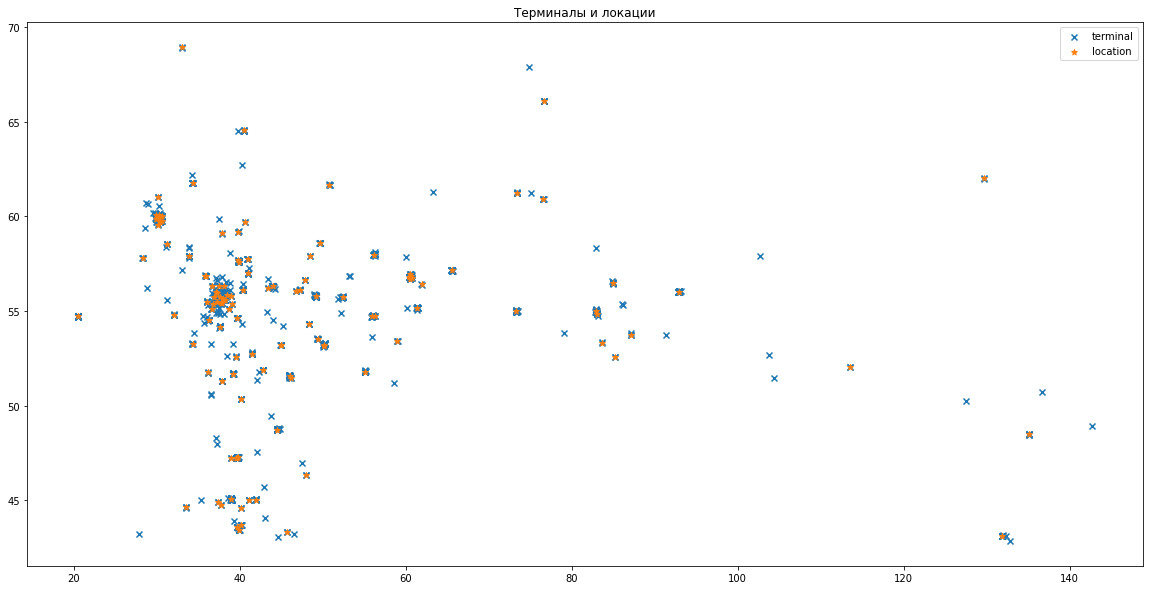

In [7]:
plt.figure(figsize=(20, 10))
plt.title('Терминалы и локации')
plt.scatter(train_df.LON, train_df.LAT, marker='x', label='terminal')
plt.scatter(locs.LON, locs.LAT, marker='*', label='location')
plt.legend()
plt.show()

In [8]:
locs.head(10)

,loc_id,LON,LAT,size,name
0,0,37.608418,55.754701,2359,Москва
1,2,30.328442,59.928426,754,Санкт-Петербург
2,3,60.589051,56.834563,99,"Свердловская область, Екатеринбург"
3,6,49.153959,55.790228,89,"Республика Татарстан, Казань"
4,14,82.928391,55.021783,56,"Новосибирск, Октябрьская магистраль"
5,34,39.001486,45.047976,35,Краснодар
6,10,56.197325,57.985030,33,Пермь
7,13,44.003024,56.312475,32,Нижний Новгород
8,17,39.717372,47.238184,29,Ростов-на-Дону
9,19,50.185062,53.228766,28,Самара


In [9]:
locs.tail(10)

,loc_id,LON,LAT,size,name
111,96,39.039327,55.381849,2,"Московская область, Егорьевск"
112,79,43.434196,56.235321,2,"Нижегородская область, Дзержинск"
113,80,40.147965,44.591633,2,"Республика Адыгея, Майкоп"
114,81,40.644706,59.710565,2,Вологодская область
115,83,45.703133,43.317104,2,"Чеченская Республика, Грозный"
116,87,129.713359,62.014280,2,"Республика Саха (Якутия), Якутск"
117,89,58.985879,53.413115,2,"Челябинская область, Магнитогорск"
118,91,28.297237,57.812557,2,Псков
119,92,30.135738,61.036162,2,"Ленинградская область, Приозерск"
120,120,45.017372,53.193725,2,Пенза


In [10]:
locs.to_csv('locations.csv', index=None)